Imports.

In [1]:
from enum import Enum
from typing import NamedTuple
import numpy as np
import math
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
import keras
from numba import njit

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Definições, inicializações e funções utilitárias.

In [2]:
#The tolerance for floating pointer comparison
epsilon = 0.000001

#The complexity of the variogram models
numberOfNestedStructures = 4
numberOfParametersPerNestedStructure = 4 #ATTENTION: if you change this value, you must change the makeVariogramModelSurface() function accordingly
totalNumberOfParameters = numberOfNestedStructures * numberOfParametersPerNestedStructure

#The target sill for the variogram models
sill = 0.64

#The range for the longest structure allowed in the variogram models
maxAxis = 50.0

class StructureType(Enum):
    Spheric     = 1
    Exponential = 2
    Gaussian    = 3
    
class EllipsoidParameters(NamedTuple):
    Azimuth      : float
    SemiMajorAxis: float
    SemiMinorAxis: float

class GridParameters(NamedTuple):
    X0: float
    Y0: float
    DX: float
    DY: float
    NI: int
    NJ: int

def getExtent2D( gridParameters : GridParameters ) -> np.array :
    gridCornerX = gridParameters.X0 - gridParameters.DX/2;
    gridCornerY = gridParameters.Y0 - gridParameters.DY/2;
    return [
           gridCornerX,
           gridCornerX + gridParameters.DX*gridParameters.NI,
           gridCornerY,
           gridCornerY + gridParameters.DY*gridParameters.NJ
           ]

def getGridParameters() -> GridParameters :
    return GridParameters( X0=-50., Y0=-50., 
                           DX=1,    DY=1, 
                           NI=100,  NJ=100 )    

Função gera superfície variográfica

In [3]:
@njit
def makeVariographicSurface( structureType       : StructureType, 
                             ellipsoidParameters : EllipsoidParameters, 
                             contribution        : float,
                             gridParameters      : GridParameters ) -> np.array :
   #NOTA VARIAVEIS COM [0] APARENTEMENTE DE FORMA DESNECESSARIA
   #sem isso dá erro de tipo não reconhecido (array) ao tentar usar com o JIT do Numba.
   #
   #Cria o numpy.array seguindo os parâmetros do grid.
   grid = np.zeros(( gridParameters.NI, gridParameters.NJ ));
   #Check for null structure
   if( contribution[0] < epsilon or 
       ellipsoidParameters.SemiMajorAxis[0] < epsilon or 
       ellipsoidParameters.SemiMinorAxis[0] < epsilon ) :
       return grid;
   #Obtem parâmetros geométricos
   a = ellipsoidParameters.SemiMajorAxis;
   b = ellipsoidParameters.SemiMinorAxis;
   c = contribution;                                       #contribution to semivariance
   theta = ellipsoidParameters.Azimuth/180.0 * math.pi; #azimuth
   xc = gridParameters.X0 - gridParameters.DX/2 + gridParameters.DX*gridParameters.NI/2; #center of the grid
   yc = gridParameters.Y0 - gridParameters.DY/2 + gridParameters.DY*gridParameters.NJ/2; #center of the grid
   #Calcula o variograma em cada célula do grid   
   for j in range( gridParameters.NJ ) :
      for i in range( gridParameters.NI ) :
         xCell = gridParameters.X0 + gridParameters.DX * i;
         yCell = gridParameters.Y0 + gridParameters.DY * j;
         x = (xCell - xc) * math.cos(theta[0]) - (yCell - yc) * math.sin(theta[0]);
         y = (xCell - xc) * math.sin(theta[0]) + (yCell - yc) * math.cos(theta[0]);
         modulusSquared = (x/a)*(x/a) + (y/b)*(y/b);
         h = math.sqrt( modulusSquared[0] );
         if( h >= 0. and h <= 1. ) :
            semivariance = c * (3*h/2.-math.pow(h, 3)/2.);
         else :
            semivariance = c;
         grid[i,j] = semivariance[0];
   #retorna o grid
   return grid;

Função para gerar a superfície de um modelo variográfico de 4 estruturas

In [4]:
# The parameters must be a linear 16-element array of floats in the following order:
# azimuth, semi-major axis, semi-minor axis, contribution, azimuth, ...
# for four structures.  Models with less than for structures can be specified with all-zero parameters
def makeVariogramModelSurface( parameters : np.array ) -> np.array :
    gridParameters = getGridParameters()
    variogramModelSurface = np.zeros(( gridParameters.NI, gridParameters.NJ ));
    for i in range( numberOfNestedStructures ) :
        variogramModelSurface += \
            makeVariographicSurface( structureType = StructureType.Spheric, 
                                     ellipsoidParameters = EllipsoidParameters( Azimuth      =parameters[i*numberOfParametersPerNestedStructure+0], 
                                                                                SemiMajorAxis=parameters[i*numberOfParametersPerNestedStructure+1], 
                                                                                SemiMinorAxis=parameters[i*numberOfParametersPerNestedStructure+2] ), 
                                     contribution=parameters[i*numberOfParametersPerNestedStructure+3],
                                     gridParameters = gridParameters )
    return variogramModelSurface;


Programa

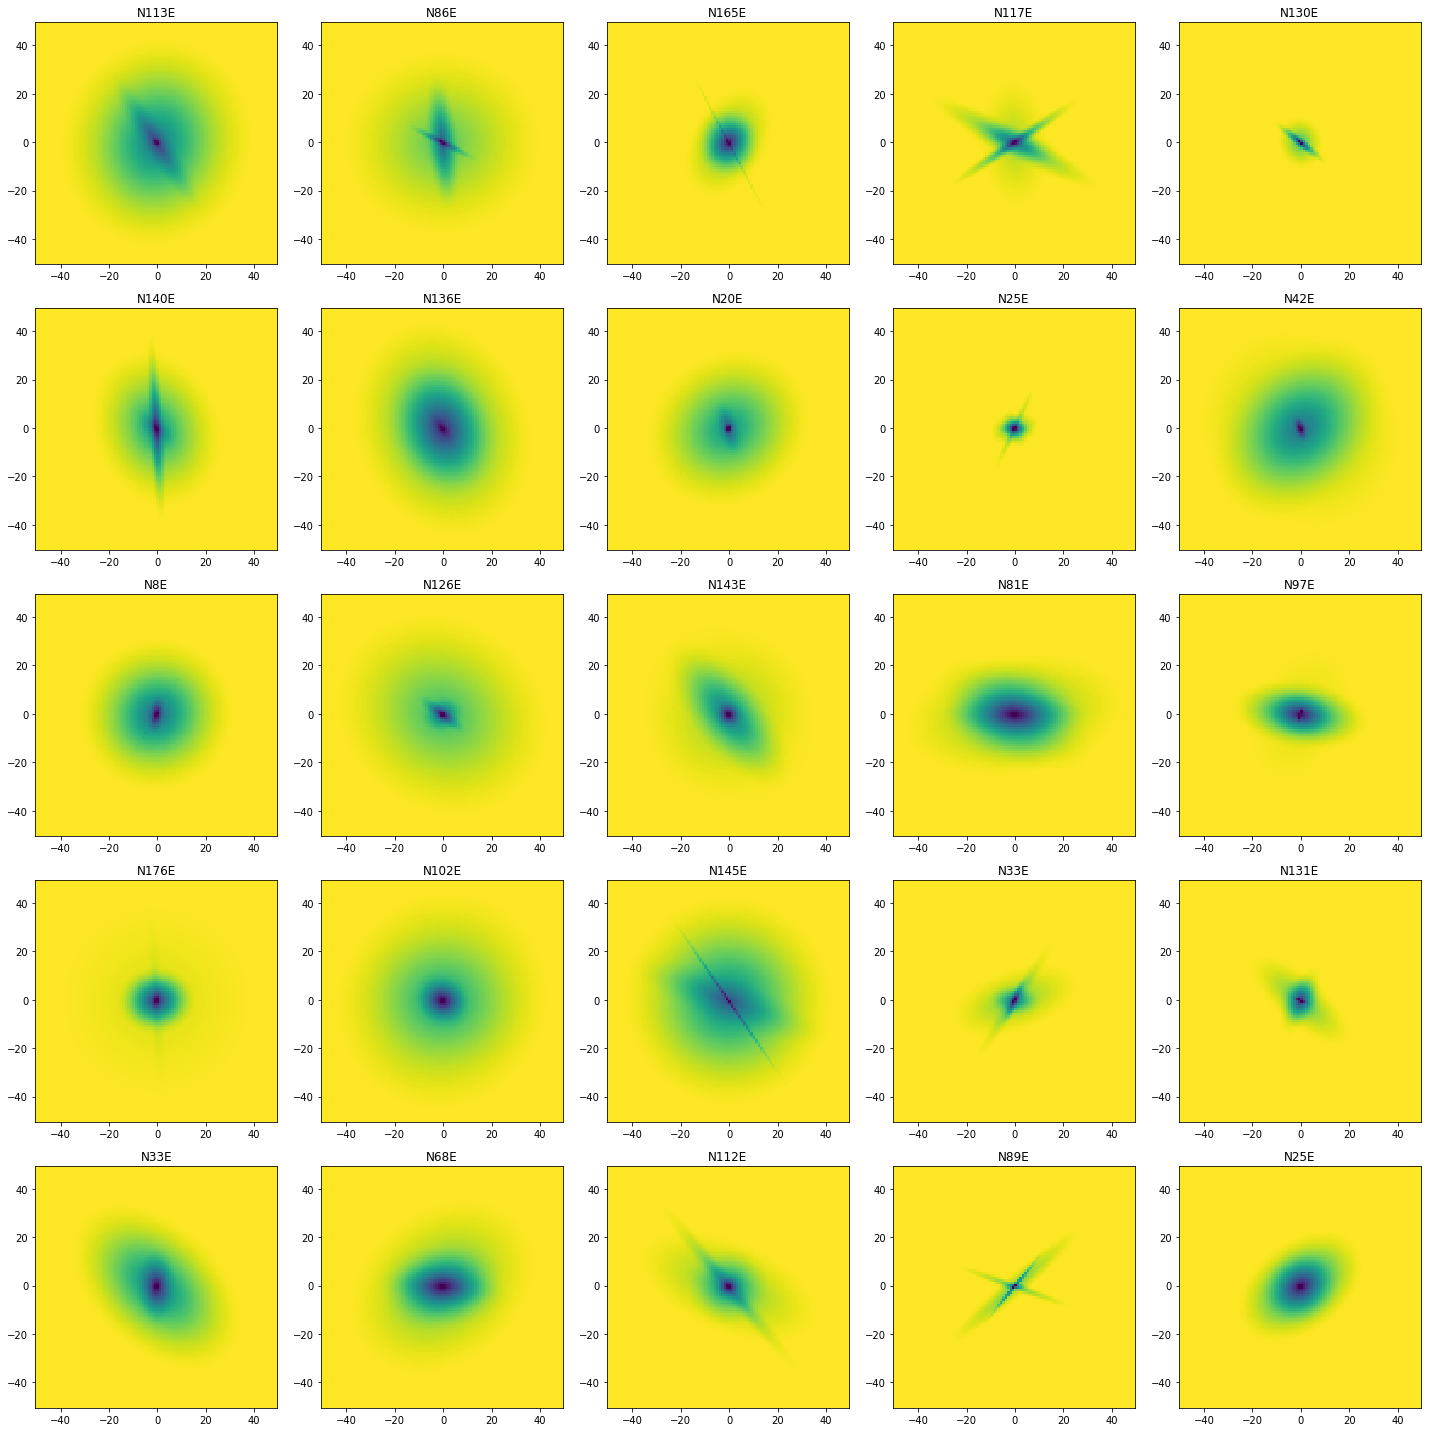

In [5]:
#The number of random variogram surfaces to generate
n = 40

#Allocate a volume for the stack of all variogram model surfaces n * 100 * 100
allVariograms = np.zeros(( n, getGridParameters().NI, getGridParameters().NJ))

#Allocate the stack of variographic parameters n * 16 * 1
allParameters = np.zeros(( n, totalNumberOfParameters, 1))

#Generate the variogram surfaces for training
for iVariogram in range(n):
    
    #Radomize the azimuths (N000E through N180E)
    az = np.random.rand(numberOfNestedStructures, 1) * 180
    
    #Randomize the semi-major axes
    a = np.random.rand(numberOfNestedStructures, 1) * maxAxis

    #Randomize the semi-minor axes such that they are necessarily smaller than the semi-major axes
    b = np.multiply( a, np.random.rand(numberOfNestedStructures, 1) )
    
    #Randomize the contributions such that they sum up to a total (variogram sill)
    cc = np.random.rand(numberOfNestedStructures, 1) 
    cc = cc / np.sum(cc) * sill
    
    #Linearize the array of variographic parameters
    linearArrayOfParameters = np.column_stack( (az, a, b, cc) ).reshape(totalNumberOfParameters,1)
    
    #Make variogram surface
    variogramModelSurface = makeVariogramModelSurface( linearArrayOfParameters );
    
    #Stack the variogram surface
    allVariograms[iVariogram,:,:] = variogramModelSurface
    
    #Stack the linearized variographic parameters
    allParameters[iVariogram,:,:] = linearArrayOfParameters


#Prepare a plot area measuring 5 by 5 figures, each measuring 20x20
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

#Plot the first 25 variogram surfaces to check data
iVariogram = int(0)
for ax in axs.flat:

    #plot the variogram surface
    ax.imshow( allVariograms[iVariogram,:,:], 
                    interpolation='none',
                    extent=getExtent2D( getGridParameters() ))
    ax.set_title( "N" + str(int(allParameters[iVariogram,0,0])) + "E")
    
    #Increment the variogram surface index/count
    iVariogram = iVariogram + 1
    
#Lay out the plots
plt.tight_layout()
plt.show()



Carregar o mapa variográfico experimental

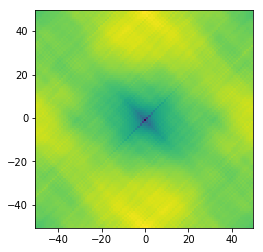

In [6]:
#Load the input experimental variogram map from teh GEO-EAS format (has some headers to skip)
experimentalVarmap = np.loadtxt(fname = "../GR_TESE_ML/value_Varmap.dat", skiprows=4)

#get the desired column (with the experimental semivariances)
experimentalVarmap = experimentalVarmap[:,0]

#reshape to 2D image
experimentalVarmap = experimentalVarmap.reshape(( getGridParameters().NI, getGridParameters().NJ ))

#plot the experimental varmap
plt.imshow( experimentalVarmap, interpolation='none', extent=getExtent2D( getGridParameters() ))

Parte de Machine Learning

In [7]:
#Normalizar os dados de entrada
#normalizer   = StandardScaler()
#X_norm = normalizer.fit_transform(X)
#ver se o normalizer traz para 0.0-1.0 mesmo
#normalizar as superfícies teóricas e o experimental na mesma escala (max de todos os mapas + experimental)
#colocar camadas de max/min pooling depois de cada camada convolutiva
#ver rede LeNet dado em um dos notebooks da aula.

#Dividir o conjunto total de superfícies variográficas e seus parâmetros em dois conjuntos:
#  1) O conjunto de treinamento, para o processamento do backpropagation.
#  2) O conjunto de teste, para aferição de métricas de acurácia da predição
trainVariograms, testVariograms, trainParameters, testParameters = \
      train_test_split(allVariograms, allParameters, test_size=0.25, random_state=11111)
    
#Talvez tenha que rescalar os variogramas para 0.0-1.0

#Compatibiliza os dados de entrada para uso no Keras, que espera tensores (matrizes de ordem maior que 2)
#de ordem 4: # de imagens, dimensão I de cada imagem, dimensão J de cada imagem, # de canais em cada imagem
trainVariograms = trainVariograms.reshape(trainVariograms.shape + (1,)) #(1,) significa uma tupla de um elemento
testVariograms  = testVariograms.reshape(testVariograms.shape + (1,))

#Cria a arquitetura de rede
model = Sequential()
model.add(Conv2D(32, kernel_size=5, strides=(3,3), activation='relu', 
                 input_shape=(getGridParameters().NI, getGridParameters().NJ, 1))) #camada convolutiva de 16 kernels (corresponde a 16 neurônios)
model.add(Conv2D(256, kernel_size=5, strides=(6,6), activation='relu')) #camada convolutiva de 8 kernels (corresponde a 8 neurônios)
model.add(Flatten()) #lineariza a imagem resultante da última camada convolutiva para 
                     #compatibilizar com camadas neuroniais seguintes
model.add(Dense(128, activation="relu")) #kernel_initializer='normal'->usa uma distribuição normal para inicializar os pesos
model.add(Dense(totalNumberOfParameters)) #camada neuronial de saída. Quando não se especifica activation, 
                                          #activation é f(x)=x comumente usada para fazer regressoes.

#Mostra o resumo da arquitetura de rede
model.summary()



Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 256)         205056    
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               819328    
_________________________________________________________________
dense_2 (Dense)              (None, 16)                2064      
Total params: 1,027,280
Trainable params: 1,027,280
Non-trainable params: 0
_________________________________________________________________


In [8]:
#compila o modelo, passando o algoritmo de otimização, a métrica para a função-objetivo e a métrica para aferir a acurácia
model.compile(optimizer=keras.optimizers.Adam(), 
              loss="mean_squared_error") #metrics=["accuracy"] não ajuda para regressões

#Compatibiliza as variáveis de resposta (parâmetros variográficos) para uso no Keras
# Remover o ultimo elemento da tupla que representa a dimensionalidade do tensor das varíaveis de resposta
my_list = list(testParameters.shape)
my_list.pop(-1) #sei que última dimensão é 1
testParameters = testParameters.reshape( tuple(my_list) )
my_list = list(trainParameters.shape)
my_list.pop(-1) #sei que última dimensão é 1
trainParameters = trainParameters.reshape( tuple(my_list) )

#treina a rede
#20% do dado de entrada serão usados como conjunto de validação, ou seja, a cada passo (época),
#a função-objetivo é avaliada usando esses dados
#run_hist = model.fit(X, y, validation_split=0.15, epochs=20)
run_hist = model.fit(trainVariograms, trainParameters, 
                     validation_data=(testVariograms, testParameters), 
                     epochs=20)




Instructions for updating:
Use tf.cast instead.
Train on 30 samples, validate on 10 samples
Epoch 1/20
30/30 [==============================] - 0s 12ms/step - loss: 3053.8711 - val_loss: 3585.9797
Epoch 2/20
30/30 [==============================] - 0s 1ms/step - loss: 3045.8716 - val_loss: 3570.6133
Epoch 3/20
30/30 [==============================] - 0s 1ms/step - loss: 3031.0042 - val_loss: 3541.2095
Epoch 4/20
30/30 [==============================] - 0s 521us/step - loss: 3002.5586 - val_loss: 3493.0356
Epoch 5/20
30/30 [==============================] - 0s 1ms/step - loss: 2956.0269 - val_loss: 3419.8164
Epoch 6/20
30/30 [==============================] - 0s 1ms/step - loss: 2885.4163 - val_loss: 3315.5183
Epoch 7/20
30/30 [==============================] - 0s 521us/step - loss: 2785.1370 - val_loss: 3173.9897
Epoch 8/20
30/30 [==============================] - 0s 1ms/step - loss: 2649.6343 - val_loss: 2990.0698
Epoch 9/20
30/30 [==============================] - 0s 1ms/step - loss:

In [13]:
#rearranja a imagem do varmap experimental para uma dimensionalidade esperada pelo Keras:
#1ª dimensao: número de imagens (no caso soh uma)
#dimensões do meio: dimensões de cada imagem
#última dimensão: número de canais por imagem (no caso soh uma) para imagens muiltiespectrais ou RGB esse valor pode variar
if( len(experimentalVarmap.shape) < 4 ) :
    experimentalVarmap = experimentalVarmap.reshape((1,) + experimentalVarmap.shape + (1,))
#realiza a regressão (predição)
y_pred  = model.predict(experimentalVarmap)

[[108.12742     38.896454     8.971172    -9.25827   ]
 [113.88171     26.529259    22.409082    -2.7739937 ]
 [141.54178     32.20911     12.126981     0.84779507]
 [127.60722     25.698677     3.2350278   -1.3770939 ]]


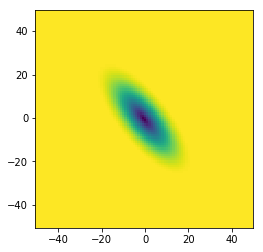

In [14]:
print(y_pred[0].reshape((4,4)))

#converte array de float32 retornado pelo Keras para array de float64 para poder chamar a funcao compilada
lala = np.zeros(( totalNumberOfParameters, 1))
lala[:,:] = y_pred.reshape((totalNumberOfParameters, 1)) 
variogramModelSurface = makeVariogramModelSurface( lala );

#plota o modelo variografico obtido
plt.imshow( variogramModelSurface, interpolation='none', extent=getExtent2D( getGridParameters() ))
